## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
df.shape
print(f'Dataframe has {df.shape[0]} observations and {df.shape[1]} features')

Dataframe has 2218 observations and 18 features


In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [6]:
#counts of response variable values
df.state.value_counts()

state
isolated    1791
released     307
deceased      32
Name: count, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [7]:
df['n_age'] = 2020-df['birth_year']
df['n_age'].head()

0    56.0
1    33.0
2    56.0
3    29.0
4    28.0
Name: n_age, dtype: float64

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [8]:
df.isna().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [10]:
df['disease'] = df['disease'].replace({np.nan: 0, True: 1})
print(df['disease'].value_counts())
print(f'The disease column now has {df['disease'].isna().sum()} missing values')

disease
0    2199
1      19
Name: count, dtype: int64
The disease column now has 0 missing values


 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

#### Global Number

In [11]:
# Calculate the Global Number mean
gn_mean = df['global_num'].mean(skipna=True)

# Fill in the misisng values
df['global_num'] = df['global_num'].replace(np.nan, gn_mean)
gn_nan = df['global_num'].isna().sum()
print(f'Global Number Mean: {gn_mean}')
print(f'Global Number column now has {gn_nan} missing values')

Global Number Mean: 4664.816590563166
Global Number column now has 0 missing values


#### Birth Year

In [12]:
by_mean = df['birth_year'].mean(skipna=True)
df['birth_year'] = df['birth_year'].replace(np.nan, by_mean)
by_nan = df['birth_year'].isna().sum()
print(f'Birth Year Mean: {by_mean}')
print(f'Birth Year column now has {by_nan} missing values')

Birth Year Mean: 1974.9886621315193
Birth Year column now has 0 missing values


#### Infection Order

In [13]:
io_mean = df['infection_order'].mean(skipna=True)
df['infection_order'] = df['infection_order'].replace(np.nan, io_mean)
io_nan = df['infection_order'].isna().sum()
print(f'Infection Order Mean: {io_mean}') 
print(f'Infection Order column missing values: {io_nan}')

Infection Order Mean: 2.2857142857142856
Infection Order column missing values: 0


#### Infected By

In [14]:
ib_mean = df['infected_by'].mean(skipna=True)
df['infected_by'] = df['infected_by'].replace(np.nan, ib_mean)
ib_nan = df['infected_by'].isna().sum()
print(f'Infected By Mean: {ib_mean}') 
print(f'Infected by column missing values: {ib_nan}')

Infected By Mean: 2600788987.586354
Infected by column missing values: 0


#### Contact Number

In [15]:
cn_mean = df['contact_number'].mean(skipna=True)
df['contact_number'] = df['contact_number'].replace(np.nan, cn_mean)
cn_nan = df['contact_number'].isna().sum()
print(f'Contact Number Mean: {cn_mean}') 
print(f'Contact Number column missing values: {cn_nan}')

Contact Number Mean: 24.128953771289538
Contact Number column missing values: 0


In [16]:
df.isna().sum()

patient_id               0
global_num               0
sex                    145
birth_year               0
age                    261
country                  0
province                 0
city                    65
disease                  0
infection_case        1055
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

#### Sex

In [17]:
df['sex'].value_counts()

sex
female    1171
male       902
Name: count, dtype: int64

In [18]:
# Since the mode is for females we'll replace the NaNs with that
# and it shouldn't drastically alter the data
df['sex'].fillna((df['sex'].mode()[0]), inplace=True)
print(f'Sex column missing values: {df['sex'].isna().sum()}')

Sex column missing values: 0


#### age and n_age

In [19]:
df['n_age'] = 2020-df['birth_year']

# We'll make age ranges to apply to the 'age' NaNs as all the birth years are there
def age_range(x):
    if x>=0 and x<10:
        return '0s'
    elif x>=10 and x<20:
        return '10s'
    elif x>=20 and x<30:
        return '20s'
    elif x>=30 and x<40:
        return '30s'
    elif x>=40 and x<50:
        return '40s'
    elif x>=50 and x<60:
        return '50s'
    elif x>=60 and x<70:
        return '60s'
    elif x>=70 and x<80:
        return '70s'
    elif x>=80 and x<90:
        return '80s'
    elif x>=90 and x<100:
        return '90s'
    elif x>=100:
        return '100s'

df['age'] = df['n_age'].apply(age_range)
print(f'The age column now has {df['age'].isna().sum()} missing values')

The age column now has 0 missing values


In [20]:
# Since birth_year has been filled in, we can reapply what we did above for n_age
print(f'The n_age column now has {df['n_age'].isna().sum()} missing values')

The n_age column now has 0 missing values


#### City

In [21]:
df['city'].value_counts()

city
Gyeongsan-si     535
Cheonan-si        98
Seongnam-si       89
Bonghwa-gun       60
Gumi-si           59
                ... 
Anseong-si         1
pocheon-si         1
Hanam-si           1
Yeongyang-gun      1
Gimje-si           1
Name: count, Length: 134, dtype: int64

In [22]:
df['city'] = df['city'].replace(np.nan, df['city'].mode()[0])
print(f'The city column now has {df['city'].isna().sum()} missing values')

The city column now has 0 missing values


#### Infection case

In [23]:
df['infection_case'].value_counts()

infection_case
contact with patient                530
etc                                 220
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      61
Onchun Church                        33
gym facility in Cheonan              30
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: count, dtype: int64

In [24]:
# Fill in missing values with etc as it's ambiguous 
# and the 2nd highest count of values in the column 
df['infection_case'] = df['infection_case'].replace(np.nan, 'etc')
print(df['infection_case'].value_counts())
print(f'Infection Case column missing values: {df['infection_case'].isna().sum()}')

infection_case
etc                                 1275
contact with patient                 530
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: count, dtype: int64
Infection Case column missing values: 0


#### Dates

In [25]:
# Convert all date objects ('symptom_onset_date','confirmed_date','released_date','deceased_date') to datetime
df['symptom_onset_date'] = pd.to_datetime(df['symptom_onset_date'])
df['confirmed_date'] = pd.to_datetime(df['confirmed_date'])
df['released_date'] = pd.to_datetime(df['released_date'])
df['deceased_date'] = pd.to_datetime(df['deceased_date'])

In [26]:
# Drop all the rows where all date columns are null
df = df.dropna(subset=['symptom_onset_date','confirmed_date','released_date','deceased_date'], how='all')

In [27]:
# Checking for null values after previous action
df[['symptom_onset_date','confirmed_date','released_date','deceased_date']].isnull().sum()

symptom_onset_date    1884
confirmed_date           0
released_date         1854
deceased_date         2045
dtype: int64

#### Symptom Onset Dates

In [28]:
# Symptom onset dates, we'll use the average between average between confirmed date
# and symptom onset date

#First filter out rows with missing symptom onset dates
df_sym_onset_filter = df[df['symptom_onset_date'].notna()]
df_sym_onset_filter['symptom_onset_date'].isnull().sum()

0

In [29]:
# Make the average between confirmed date and symptom onset date
avg_conf_sym = np.mean(
    df_sym_onset_filter['confirmed_date'] - df_sym_onset_filter['symptom_onset_date'])
print(f'Average time between symptom onset date and confirmed date is {avg_conf_sym}')

Average time between symptom onset date and confirmed date is 4 days 06:57:49.430051813


In [30]:
# Fill in missing values with the confirmed date minus the average
# Of the symptom onset date to confirmed date
df['symptom_onset_date'] = df['symptom_onset_date'].fillna(df['confirmed_date']-avg_conf_sym)

# Now to check
print(f'Symptom onset date column has {df['symptom_onset_date'].isnull().sum()} missing values')
print(df[['symptom_onset_date','confirmed_date','released_date','deceased_date']].isnull().sum())

Symptom onset date column has 0 missing values
symptom_onset_date       0
confirmed_date           0
released_date         1854
deceased_date         2045
dtype: int64


#### Released Dates

In [31]:
# For released date we will fill in the missing values with
# the average between the confirmed date and release date

# Filter out rows that have missing values in release date
df_rel_filter = df[df['released_date'].notna()]
df_rel_filter['released_date'].isnull().sum()

0

In [32]:
# Get averages between confirmed date and released date
avg_rel_conf = np.mean(
    df_rel_filter['released_date'] - df_rel_filter['confirmed_date'])
print(f'Average time between confirmed date and released date is {avg_rel_conf}')

Average time between confirmed date and released date is 13 days 19:54:37.130044843


In [33]:
# Let's see how many rows there are no release dates, but state is 'released'
df['state'].loc[(df['released_date'].isnull()) & (df['state'] == 'released')].count()

84

In [34]:
# 84 rows to fill where the state is released, but no released date
fill_in_later = df['released_date'].loc[(df['released_date'].isnull()) & (df['state'] == 'released')]
fill_in_later = df['confirmed_date'] + avg_rel_conf

#### Deceased Date

In [35]:
#Filter out rows where deceased dates have missing values
dec_date_filter = df[df['deceased_date'].notna()]
dec_date_filter['deceased_date'].isna().sum()

0

In [36]:
# Find average time between confirmed date and deceased date
conf_to_dec_avg = np.mean(
    dec_date_filter['deceased_date']-dec_date_filter['confirmed_date'])
print(f'Average time between confirmed date and deceased date is {conf_to_dec_avg}')

Average time between confirmed date and deceased date is 3 days 17:15:00


In [37]:
# Find any rows where the state is deceased, but no deceased date
df.loc[(df['deceased_date'].isnull()) & (df['state'] == 'deceased')]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
1611,6002000002,4664.816591,male,1980.0,40s,Korea,Gyeongsangbuk-do,Gyeongju-si,0,etc,2.285714,2.600789e+09,24.128954,2020-02-17 17:02:10.569948187,2020-02-22,NaT,NaT,deceased,40.0


In [38]:
# Just 1 row to update luckily
df.loc[1611, 'deceased_date'] = df.loc[1611, 'confirmed_date'] + conf_to_dec_avg

# Verifying
df.iloc[[1611]]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
1611,6002000002,4664.816591,male,1980.0,40s,Korea,Gyeongsangbuk-do,Gyeongju-si,0,etc,2.285714,2.600789e+09,24.128954,2020-02-17 17:02:10.569948187,2020-02-22,NaT,2020-02-25 17:15:00,deceased,40.0


In [39]:
# Let's look for any rows where there are deceased dates, but state doesn't say deceased
df.loc[(df['deceased_date'].notnull()) & (df['state'] != 'deceased')]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
109,1000000110,6781.0,male,1964.0,50s,Korea,Seoul,Gangnam-gu,0,contact with patient,2.285714,2.600789e+09,24.128954,2020-03-02 17:02:10.569948187,2020-03-07,NaT,2020-03-19,released,56.0
187,1000000188,7561.0,female,1994.0,20s,Korea,Seoul,Dongdaemun-gu,0,contact with patient,2.285714,1.000000e+09,24.128954,2020-03-05 17:02:10.569948187,2020-03-10,NaT,2020-03-19,released,26.0


In [40]:
# Correct those 2 rows for the states to be deceased
df.loc[[109,187], 'state'] = 'deceased'
df.loc[[109,187]]

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
109,1000000110,6781.0,male,1964.0,50s,Korea,Seoul,Gangnam-gu,0,contact with patient,2.285714,2.600789e+09,24.128954,2020-03-02 17:02:10.569948187,2020-03-07,NaT,2020-03-19,deceased,56.0
187,1000000188,7561.0,female,1994.0,20s,Korea,Seoul,Dongdaemun-gu,0,contact with patient,2.285714,1.000000e+09,24.128954,2020-03-05 17:02:10.569948187,2020-03-10,NaT,2020-03-19,deceased,26.0


#### State

In [41]:
# As for the rest of the state column missing values, we'll fill it in with the mode
df['state'] = df['state'].replace(np.nan, df['state'].mode()[0])

 **<font color='teal'> Check for any remaining null values.</font>**

In [42]:
df.isnull().sum()

patient_id               0
global_num               0
sex                      0
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date       0
confirmed_date           0
released_date         1854
deceased_date         2044
state                    0
n_age                    0
dtype: int64

In [43]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22 00:00:00.000000000,2020-01-23,2020-02-05,NaT,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,2020-01-25 17:02:10.569948187,2020-01-30,2020-03-02,NaT,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,2020-01-25 17:02:10.569948187,2020-01-30,2020-02-19,NaT,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26 00:00:00.000000000,2020-01-30,2020-02-15,NaT,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,2020-01-26 17:02:10.569948187,2020-01-31,2020-02-24,NaT,released,28.0


Remove date columns from the data.


In [44]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Review the count of unique values by column.

In [45]:
print(df.nunique())

patient_id         2077
global_num         1304
sex                   2
birth_year           97
age                  11
country               4
province             17
city                130
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                97
dtype: int64


Review the percent of unique values by column.

In [46]:
print('Unique values by column as %')
print(df.nunique()/df.shape[0] * 100)

Unique values by column as %
patient_id         100.000000
global_num          62.782860
sex                  0.096293
birth_year           4.670197
age                  0.529610
country              0.192585
province             0.818488
city                 6.259027
disease              0.096293
infection_case       0.770342
infection_order      0.337025
infected_by          9.966298
contact_number       3.514685
state                0.144439
n_age                4.670197
dtype: float64


Review the range of values per column.

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2077.0,3.879120e+09,2.200900e+09,1.000000e+09,1.600000e+09,4.100000e+09,6.001000e+09,7.000000e+09
global_num,2077.0,4.664817e+03,2.285663e+03,1.000000e+00,3.947000e+03,4.664817e+03,6.146000e+03,8.717000e+03
birth_year,2077.0,1.975001e+03,1.788104e+01,1.916000e+03,1.964000e+03,1.974989e+03,1.990000e+03,2.020000e+03
disease,2077.0,9.147809e-03,9.522864e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2077.0,2.285852e+00,1.762510e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2077.0,2.601463e+09,7.451022e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2077.0,2.412895e+01,4.047981e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2077.0,4.499931e+01,1.788104e+01,0.000000e+00,3.000000e+01,4.501134e+01,5.600000e+01,1.040000e+02


### Check for duplicated rows

In [48]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [49]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
print(dfo.shape)
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

(2077, 7)


,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,130
5,infection_case,16
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

<Axes: title={'center': 'Heatmap Correlation of Features'}>

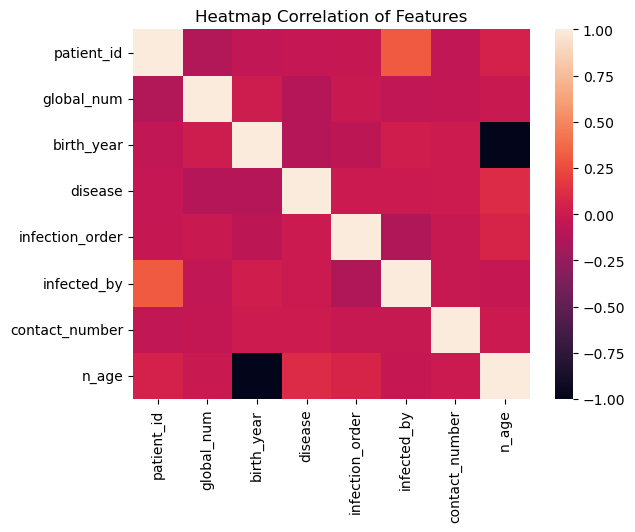

In [55]:
plt.title('Heatmap Correlation of Features')
sns.heatmap(df.corr(numeric_only=True))

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

<Axes: >

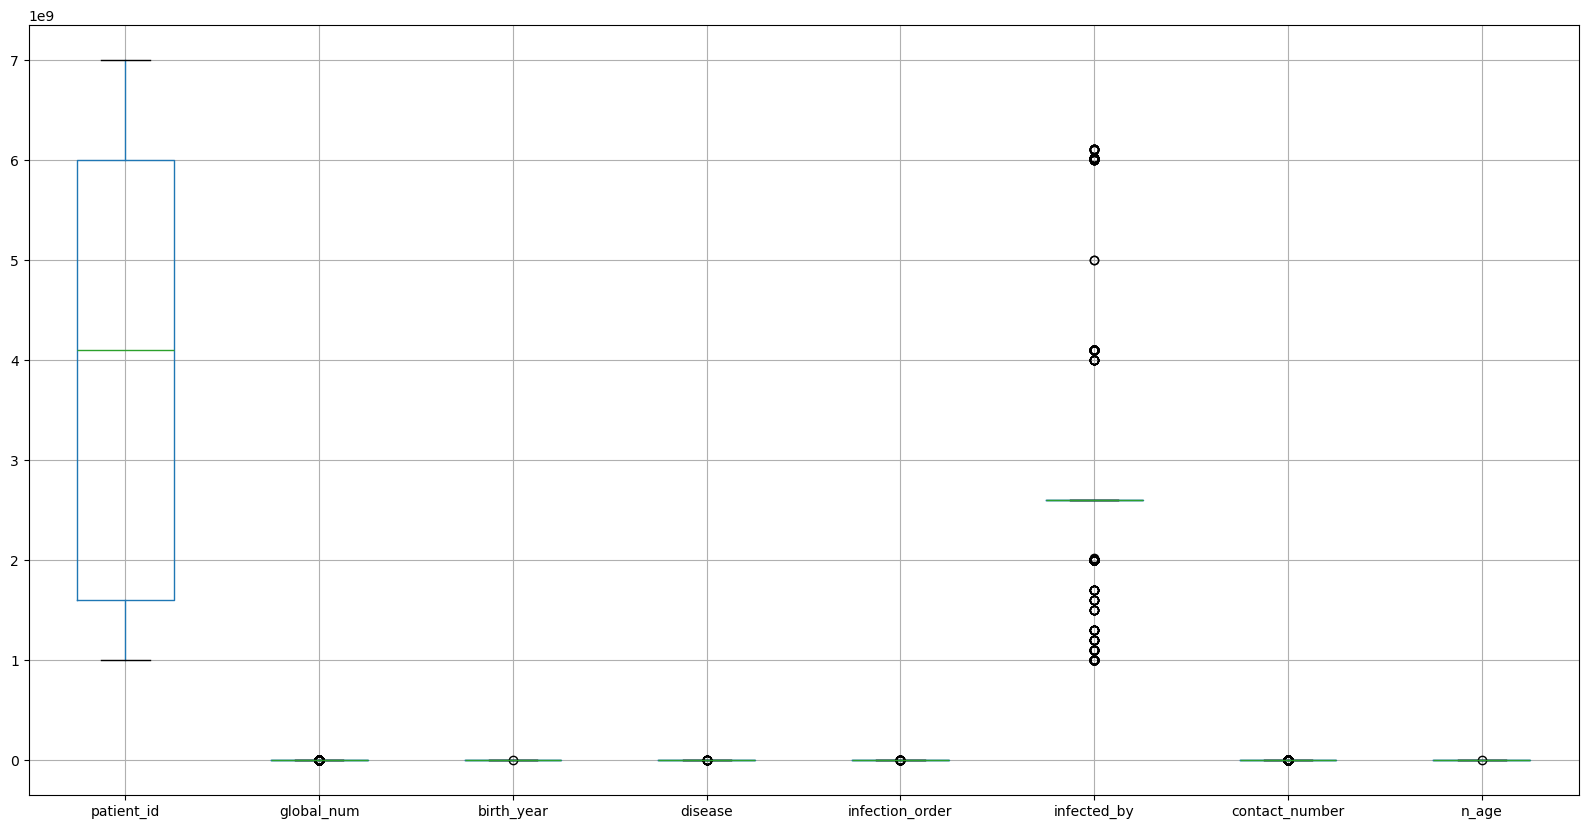

In [56]:
plt.figure(figsize=(20,10))
df.boxplot()

**<font color='teal'> Create dummy features for object type features. </font>**

In [57]:
obj_feats = ['sex', 'age', 'country', 'province', 'city', 'infection_case']
dumms = pd.get_dummies(df[obj_feats])
df0 = pd.concat([df, dumms], axis=1)
df_final = df0.drop(obj_feats, axis=1)

### Split the data into test and train subsamples

In [58]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
features_final = df_final.columns.drop('state')

X = df_final[features_final]
y = df_final['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [59]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [60]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [61]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.873
Random Forest: f1-score=0.847


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [62]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  6   1   0]
 [  0 346   9]
 [  0  43  11]]
Normalized confusion matrix
[[0.86 0.14 0.  ]
 [0.   0.97 0.03]
 [0.   0.8  0.2 ]]


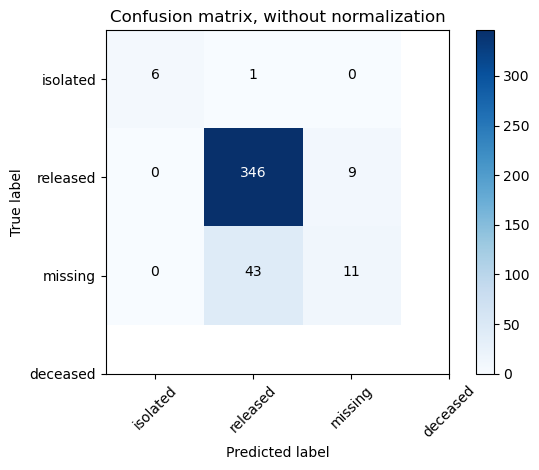

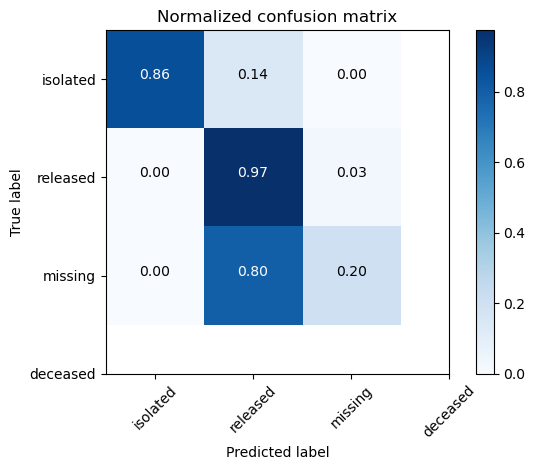

In [63]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


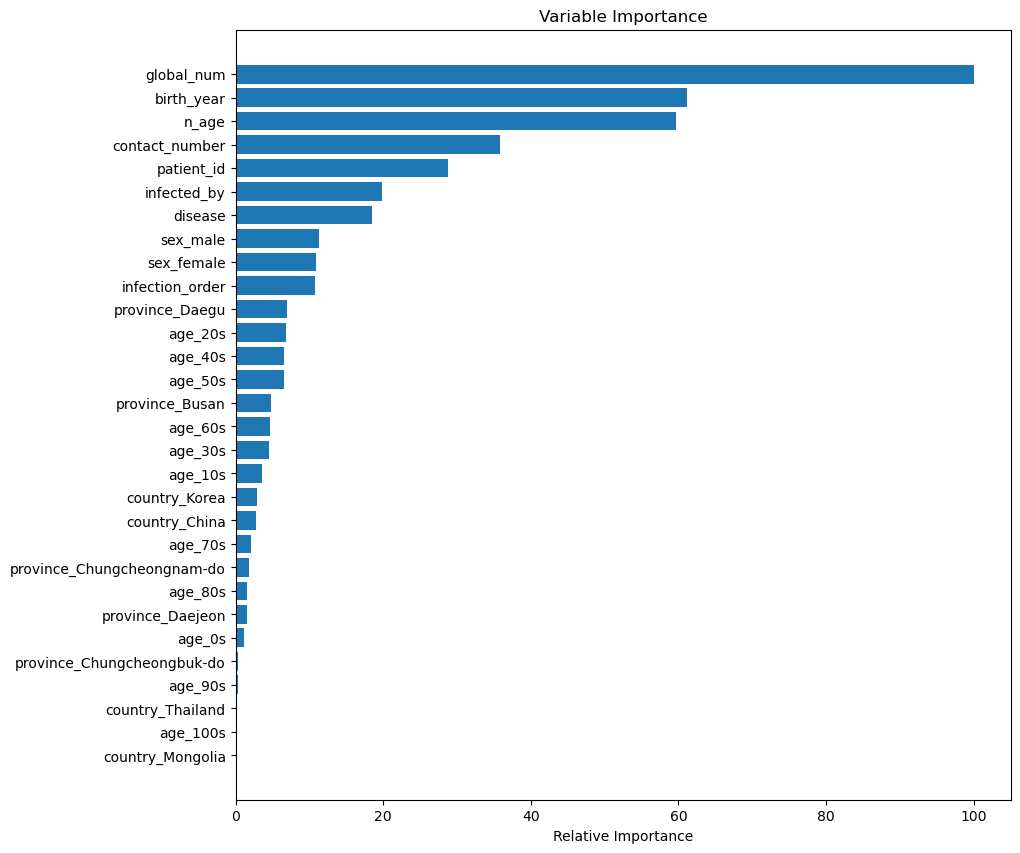

In [64]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.